In [141]:
from create_model import data_gathering_pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
import tensorflow as tf
from tensorflow import keras
import tensorflowjs as tfjs
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Collect, visualize and process data

In [2]:
data = data_gathering_pipeline()
df = pd.DataFrame(data)

df

,weekday,hour,minute,timestamp,n_carros,temperature,weather_condition
0,1,19,14,2023-05-16 19:14:47.232901,8,20.0,Sunny
1,1,19,20,2023-05-16 19:20:01.271561,13,21.0,Sunny
2,1,19,25,2023-05-16 19:25:13.774136,13,21.0,Sunny
3,1,19,30,2023-05-16 19:30:26.469829,13,21.0,Sunny
4,1,19,35,2023-05-16 19:35:39.685086,12,21.0,Sunny
...,...,...,...,...,...,...,...
1858,6,19,36,2023-05-21 19:36:53.114320,8,20.0,Sunny
1859,6,19,40,2023-05-21 19:40:05.414656,9,20.0,Sunny
1860,6,19,43,2023-05-21 19:43:18.063494,8,20.0,Sunny
1861,6,19,46,2023-05-21 19:46:30.505655,8,20.0,Sunny


In [21]:
df.describe()

,weekday,hour,minute,n_carros,temperature
count,1863.000000,1863.000000,1863.000000,1863.000000,1863.000000
mean,3.861514,11.994632,29.563607,7.971014,19.006602
std,1.455806,6.235873,17.230980,4.820764,2.897036
min,1.000000,0.000000,0.000000,0.000000,10.400000
25%,3.000000,7.000000,15.000000,4.000000,17.000000
50%,4.000000,12.000000,30.000000,10.000000,19.000000
75%,5.000000,17.000000,44.000000,12.000000,21.000000
max,6.000000,23.000000,59.000000,14.000000,24.000000


<AxesSubplot:xlabel='weather_condition', ylabel='Count'>

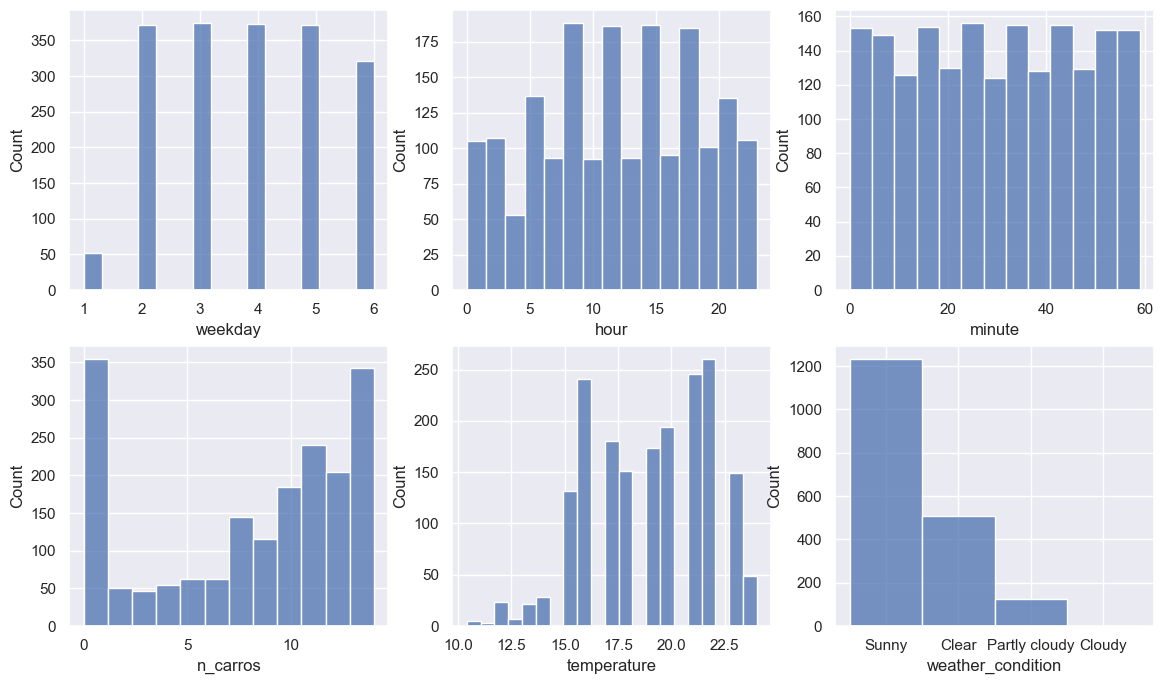

In [177]:
sns.set(rc={'figure.figsize':(14, 8)})
fig, axs = plt.subplots(ncols=3, nrows=2)
sns.histplot(df.weekday, ax=axs[0][0])
sns.histplot(df.hour, ax=axs[0][1])
sns.histplot(df.minute, ax=axs[0][2])
sns.histplot(df.n_carros, ax=axs[1][0])
sns.histplot(df.temperature, ax=axs[1][1])
sns.histplot(df.weather_condition, ax=axs[1][2])

<AxesSubplot:xlabel='timestamp', ylabel='n_carros'>

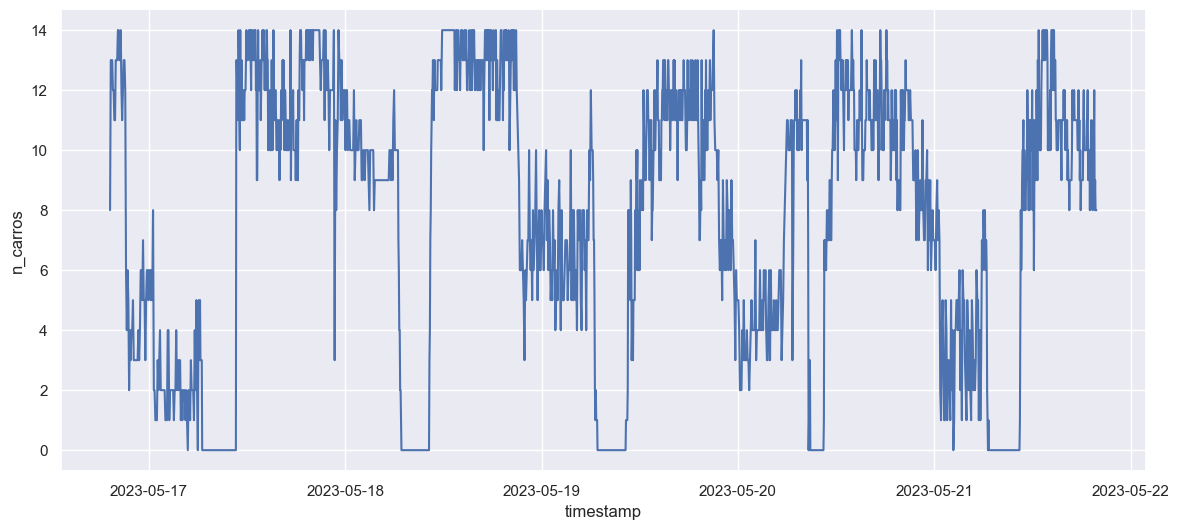

In [178]:
sns.set(rc={'figure.figsize':(14, 6)})
sns.lineplot(data=df, x="timestamp", y="n_carros")

<AxesSubplot:xlabel='hour', ylabel='n_carros'>

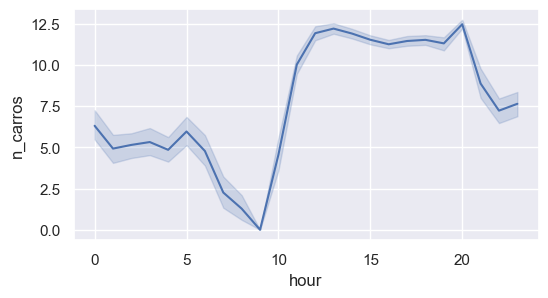

In [49]:
sns.set(rc={'figure.figsize':(6, 3)})
sns.lineplot(data=df, x="hour", y="n_carros")


Entre as 21h e as 11h, a contagem é mais imprecisa. Isto deve-se ao facto de ser de noite e haver pouca luminosidade, e ao nascer do sol haver um reflexo no vidro que faz que com o modelo não consiga fazer tão bem as deteções.

Para o treino do modelo estes valores têm de ser corrigidos. Para isso vão fazer substituídos pela media da lotação do estacionamento durante as 3 horas do dia.

In [50]:
df_processed = df.copy()

for i in range(1, 7):
    df_processed.loc[(df_processed['weekday'] == i) & ((df_processed['hour'] >= 21) | (df_processed['hour'] <= 10)), 'n_carros'] = int(df_processed.loc[(df_processed['weekday'] == i) & (df_processed['hour'] >= 19) & (df_processed['hour'] <= 21), 'n_carros'].mean())

<AxesSubplot:xlabel='hour', ylabel='n_carros'>

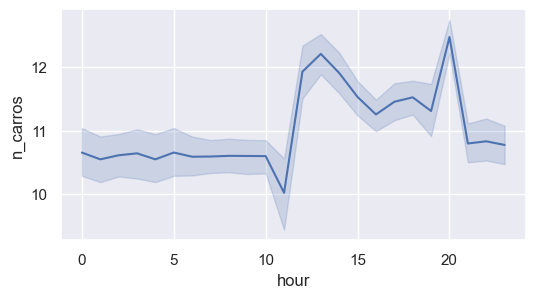

In [51]:
sns.set(rc={'figure.figsize':(6, 3)})
sns.lineplot(data=df_processed, x="hour", y="n_carros")

In [52]:
df_processed.describe()

,weekday,hour,minute,n_carros,temperature
count,1863.000000,1863.000000,1863.000000,1863.000000,1863.000000
mean,3.861514,11.994632,29.563607,11.088030,19.006602
std,1.455806,6.235873,17.230980,1.671709,2.897036
min,1.000000,0.000000,0.000000,3.000000,10.400000
25%,3.000000,7.000000,15.000000,10.000000,17.000000
50%,4.000000,12.000000,30.000000,11.000000,19.000000
75%,5.000000,17.000000,44.000000,13.000000,21.000000
max,6.000000,23.000000,59.000000,14.000000,24.000000


<AxesSubplot:xlabel='timestamp', ylabel='n_carros'>

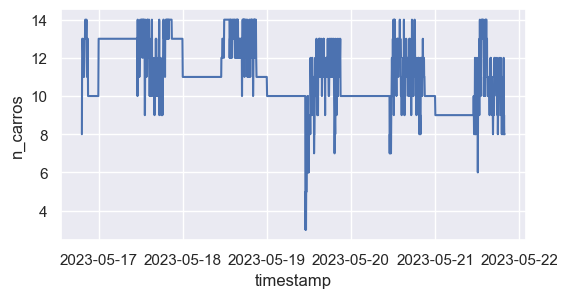

In [53]:
sns.lineplot(data=df_processed, x="timestamp", y="n_carros")

Existem alguns outliers. Estes seram detetados através da técnica IQR e substituídos pela média.

<AxesSubplot:>

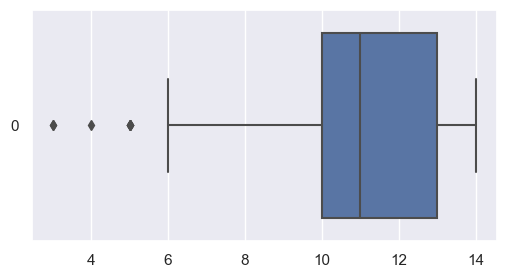

In [54]:
sns.set(rc={'figure.figsize':(6, 3)})
sns.boxplot(data=df_processed.n_carros, orient='h')

In [56]:
def find_outliers_IQR(df):
   q1=df.quantile(0.25)
   q3=df.quantile(0.75)
   IQR=q3-q1
   outliers = df[((df<(q1-1.5*IQR)) | (df>(q3+1.5*IQR)))]
   return outliers

def impute_outliers_IQR(df):
   q1=df.quantile(0.25)
   q3=df.quantile(0.75)
   IQR=q3-q1
   upper = df[~(df>(q3+1.5*IQR))].max()
   lower = df[~(df<(q1-1.5*IQR))].min()

   df = np.where(df > upper,
       df.mean(),
       np.where(
           df < lower,
           df.mean(),
           df
           )
       )

   return df

df_processed['n_carros'] = impute_outliers_IQR(df_processed['n_carros'])


<AxesSubplot:>

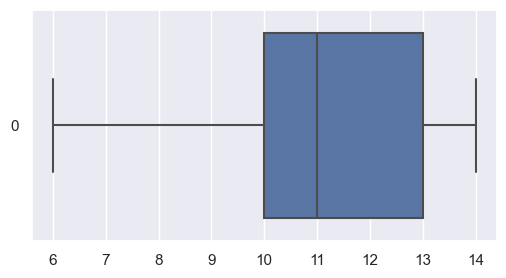

In [57]:
sns.set(rc={'figure.figsize':(6, 3)})
sns.boxplot(data=df_processed.n_carros, orient='h')

# Train Model

In [62]:
dataset = df_processed.copy()
dataset.loc[(dataset['weather_condition'] != "Rainy"), 'weather_condition'] = 1
dataset.loc[(dataset['weather_condition'] == "Rainy"), 'weather_condition'] = 0
dataset['weather_condition'] = pd.to_numeric(dataset["weather_condition"])
dataset

,weekday,hour,minute,timestamp,n_carros,temperature,weather_condition
0,1,19,14,2023-05-16 19:14:47.232901,8.0,20.0,1
1,1,19,20,2023-05-16 19:20:01.271561,13.0,21.0,1
2,1,19,25,2023-05-16 19:25:13.774136,13.0,21.0,1
3,1,19,30,2023-05-16 19:30:26.469829,13.0,21.0,1
4,1,19,35,2023-05-16 19:35:39.685086,12.0,21.0,1
...,...,...,...,...,...,...,...
1858,6,19,36,2023-05-21 19:36:53.114320,8.0,20.0,1
1859,6,19,40,2023-05-21 19:40:05.414656,9.0,20.0,1
1860,6,19,43,2023-05-21 19:43:18.063494,8.0,20.0,1
1861,6,19,46,2023-05-21 19:46:30.505655,8.0,20.0,1


In [60]:
train_rows = df.sample(frac = 0.9)
df_train = dataset.iloc[train_rows.index]
df_test = dataset.drop(df_train.index, axis=0)

print(df_train.shape, df_test.shape)

(1677, 7) (186, 7)


In [179]:
X, y = dataset.drop(['n_carros', 'timestamp', 'weather_condition'], axis=1), dataset.n_carros

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.85)
X_train, y_train

(      weekday  hour  minute  temperature
 879         4     7       6         13.0
 1545        6     0      21         17.0
 1347        5    12      16         21.0
 1187        5     1      39         16.0
 87          2     3      19         17.0
 ...       ...   ...     ...          ...
 74          2     2       6         12.8
 114         2     5      52         16.0
 1777        6    15      17         21.0
 1137        4    20      56         18.0
 249         2    13      20         23.0
 
 [279 rows x 4 columns],
 879     10.0
 1545     9.0
 1347    13.0
 1187    10.0
 87      13.0
         ... 
 74      13.0
 114     13.0
 1777    11.0
 1137    13.0
 249     14.0
 Name: n_carros, Length: 279, dtype: float64)

In [209]:
model = keras.Sequential([
    keras.layers.Dense(64, activation='relu', input_shape=[len(X.keys())]),
    keras.layers.Dense(32, activation='relu'),
    # keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(16, activation='relu'),
    keras.layers.Dense(1, activation='relu')
])

model.compile(optimizer=tf.keras.optimizers.RMSprop(0.0003),
            loss='mse',
            metrics=['mae', 'mse'])

model.summary()

Model: "sequential_37"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_136 (Dense)           (None, 64)                320       
                                                                 
 dense_137 (Dense)           (None, 32)                2080      
                                                                 
 dense_138 (Dense)           (None, 16)                528       
                                                                 
 dense_139 (Dense)           (None, 1)                 17        
                                                                 
Total params: 2,945
Trainable params: 2,945
Non-trainable params: 0
_________________________________________________________________


In [210]:
history = model.fit(X_train, y_train, epochs=300)

preds = model.predict(X_test)
mean_absolute_error(y_test, preds), mean_squared_error(y_test, preds)

Epoch 1/300
9/9 [==============================] - 1s 2ms/step - loss: 24.6245 - mae: 4.2679 - mse: 24.6245
Epoch 2/300
9/9 [==============================] - 0s 2ms/step - loss: 17.1571 - mae: 3.5603 - mse: 17.1571
Epoch 3/300
9/9 [==============================] - 0s 2ms/step - loss: 13.2365 - mae: 3.0966 - mse: 13.2365
Epoch 4/300
9/9 [==============================] - 0s 2ms/step - loss: 10.2709 - mae: 2.7162 - mse: 10.2709
Epoch 5/300
9/9 [==============================] - 0s 2ms/step - loss: 7.8211 - mae: 2.3269 - mse: 7.8211
Epoch 6/300
9/9 [==============================] - 0s 2ms/step - loss: 5.9099 - mae: 2.0079 - mse: 5.9099
Epoch 7/300
9/9 [==============================] - 0s 2ms/step - loss: 4.5834 - mae: 1.7279 - mse: 4.5834
Epoch 8/300
9/9 [==============================] - 0s 2ms/step - loss: 3.9175 - mae: 1.5735 - mse: 3.9175
Epoch 9/300
9/9 [==============================] - 0s 2ms/step - loss: 3.6306 - mae: 1.5002 - mse: 3.6306
Epoch 10/300
9/9 [====================

(1.1781479193234552, 2.250186801926212)

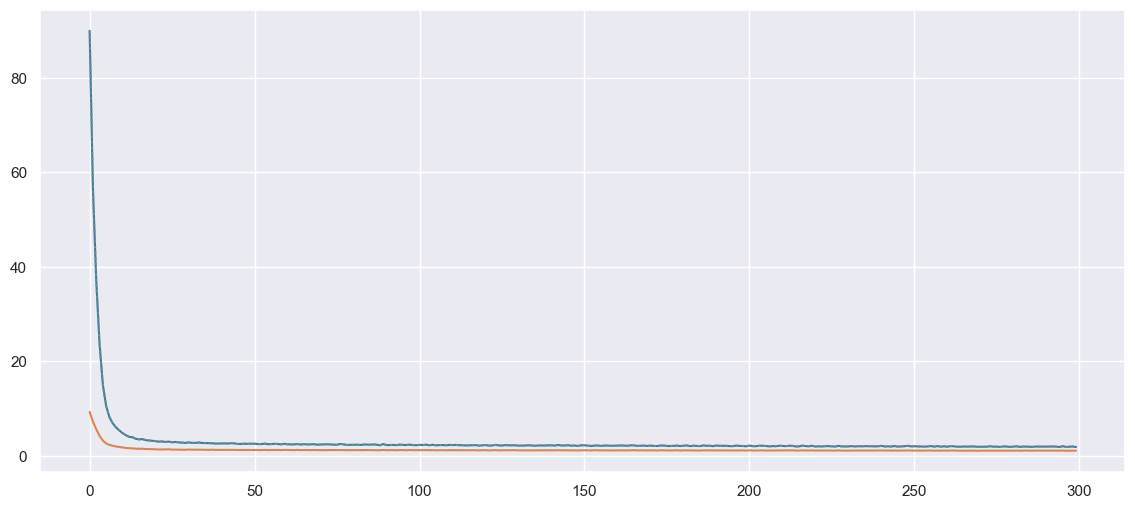

In [206]:
plt.plot(history.history['mse'])
plt.plot(history.history['mae'])
plt.plot(history.history['loss'], linestyle = 'dotted')
plt.show()

<AxesSubplot:ylabel='Count'>

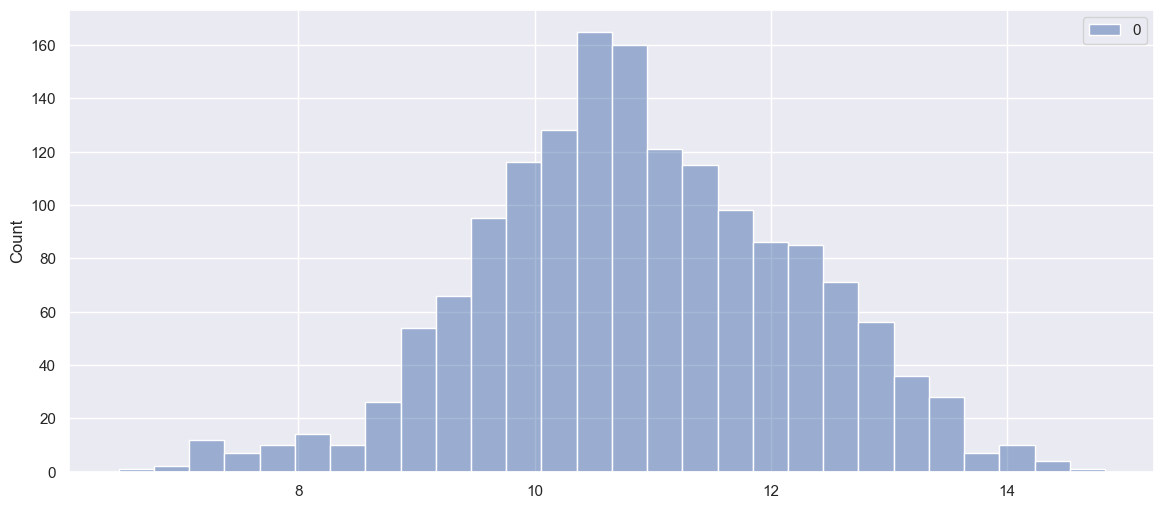

In [202]:
sns.histplot(preds)

In [212]:
X_test.iloc[0], y_test.iloc[0], preds[0]

(weekday         5.0
 hour           22.0
 minute         11.0
 temperature    19.0
 Name: 1522, dtype: float64,
 10.0,
 array([9.962063], dtype=float32))

In [185]:
X_test.iloc[0].values, model.predict(np.array([X_test.iloc[0].values]))

1/1 [==============================] - 0s 91ms/step


(array([ 5., 22., 11., 19.]), array([[10.422969]], dtype=float32))

In [211]:
tfjs.converters.save_keras_model(model, './models/modelv5')